# Neural Network for binary classification using finite difference approximation to update the weights, Leaky ReLu in between the layers and sigmoid for the output

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib as mpl
global_dpi = 120
mpl.rcParams['figure.dpi']= global_dpi

# Generate dummy data

In [84]:
_input = []
output = []
input_dims = 5
std_dev = 0.15
number_of_points = 200
for i in range(number_of_points):
    intie = np.random.randint(0,2)
    if intie == 1:
        output.append(intie)
        data = np.ones(input_dims)
        data = np.asarray([np.random.normal(intie,std_dev) for x in data])
        _input.append(copy.deepcopy(data))
    else:
        output.append(intie)
        data = np.ones(input_dims)
        data = np.asarray([np.random.normal(intie,std_dev) for x in data])
        _input.append(copy.deepcopy(data))
_input = np.asarray(_input)
output = np.asarray(output)

# Normalize input per variable (column)

In [85]:
_input = _input.T
for i in _input:
    mini = np.min(i)
    maxi = np.max(i)
    for k in range(len(i)):
        i[k] = (i[k]-mini)/(maxi-mini)
_input = _input.T

# Split dummy data

In [86]:
fraction = 0.7
index = number_of_points*0.7
index = int(np.floor(index))
train_x = _input[:index,:]
train_y = output[:index]
test_x = _input[index:,:]
test_y = output[index:]

# Neural Network for binary classification

In [87]:
class Neural_network:
    def __init__(self,layers):
        self.layers = layers
        self.calc_acc = False
        ################## Outputs
        self.losses = []
        self.accuracies = []
        self.test_accuracies = []
        self.test_losses = []
        #################################
        ###################### Initialize weights randomly
        weights = []
        for i in range(len(layers)-1):
            cols =layers[i]
            rows = layers[i+1]
            w = np.random.uniform(-1,1,size = (rows,cols))
            weights.append(copy.deepcopy(w))
        self.weights = weights
        #################################
    def leaky_relu(self,x):
        result = []
        for i in x:
            result.append(max(0.01*i,i))
        return np.asarray(result)
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    def loss(self,p,y):
        for i in range(len(p)):
            ##tolerance
            p[i] = min(p[i],0.9995)
            p[i] = max(0.0005,p[i])
            ###
        -(y*np.log(p)+(1-y)*np.log(1-p))
        return np.asarray(-(y*np.log(p)+(1-y)*np.log(1-p)))
    def predict(self,x,weights = None, custom = False):
        if not custom:
            weights = self.weights
        predictions = []
        if len(x.shape) == 2:
            for b in x:
                cache = b
                counter = 0 
                for i in weights:
                    cache = np.dot(i,cache)
                    if counter < (len(weights)-1):
                        cache = self.leaky_relu(cache)
                    else:
                        cache = self.sigmoid(cache)
                    counter = counter + 1
                predictions.append(cache[0])
        elif len(x.shape) == 1:
            cache = x
            counter = 0 
            for i in weights:
                cache = np.dot(i,cache)
                if counter < (len(weights)-1):
                    cache = self.leaky_relu(cache)
                else:
                    cache = self.sigmoid(cache)
                counter = counter + 1
            predictions.append(cache[0])
        else:
            raise Exception('Unsupported input dimensions: ' + str(x.shape))
        return np.asarray(predictions)
    
    def gradients(self,x,y,derriv_step_size = 0.00001):
        ## calculate current loss
        predictions = self.predict(x)
        current_loss = self.loss(predictions,y)
        current_loss = np.sum(current_loss)
        ##### Train losses
        self.losses.append(current_loss)
        ##########
        ##### Train accuracies
        if self.calc_acc:
            self.accuracies.append(self.accuracy(predictions,y))
        #####
        init_gradients = []
        for i in self.weights:
            init_gradients.append(np.zeros((i.shape)))
        for i in range(len(self.weights)):
            for k in range(self.weights[i].shape[0]):
                for j in range(self.weights[i].shape[1]):
                    weights = copy.deepcopy(self.weights)
                    weights[i][k,j] += derriv_step_size
                    predictions = self.predict(x,weights = weights,custom = True)
                    new_loss = np.sum(self.loss(predictions,y))
                    gradient = (new_loss-current_loss)/derriv_step_size
                    init_gradients[i][k,j] = gradient
        return init_gradients
    def train(self,x,y,step_size = 0.005,iters =10,derriv_step_size = 0.00001,calc_acc = True, calc_test = False, x_test = None, y_test = None):
        self.calc_acc = calc_acc
        for i in range(iters):
        ################ add all to lists
            if calc_test:
                predictions = self.predict(x_test)
                self.test_losses.append(np.sum(self.loss(predictions,y_test)))
                self.test_accuracies.append(self.accuracy(predictions,y_test) )
        #################
        
            #### Update weights
            grads = self.gradients(x,y,derriv_step_size = derriv_step_size)
            for w,g in zip(self.weights,grads):
                w += - step_size*g
            #####
            
        ###### final outputs here
        predictions = self.predict(x)
        self.losses.append(np.sum(self.loss(predictions,y)))
        if calc_acc:
            self.accuracies.append(self.accuracy(predictions,y))
        if calc_test:
            predictions = self.predict(x_test)
            self.test_losses.append(np.sum(self.loss(predictions,y_test))) 
            self.test_accuracies.append(self.accuracy(predictions,y_test))
        ############### 
    def accuracy(self,p,y):
        cache =  copy.deepcopy(p)
        for i in range(len(cache)):
            if cache[i] >= 0.5:
                cache[i] = 1
            else:
                cache[i] = 0
        cache = [int(i) for i in cache]
        total = 0
        correct = 0
        for i,j in zip(cache,y):
            if i == j:
                correct += 1
            total += 1
        return correct/total

# Test Neural Network

In [97]:
### First layer of input dimension and last layer of dimension 1 (sigmoid)
NN = Neural_network([input_dims,3,1])
####
NN.train(train_x,train_y,iters = 1000,step_size = 0.005,derriv_step_size = 0.00001,
         calc_acc = True, calc_test = True, x_test = test_x, y_test = test_y)

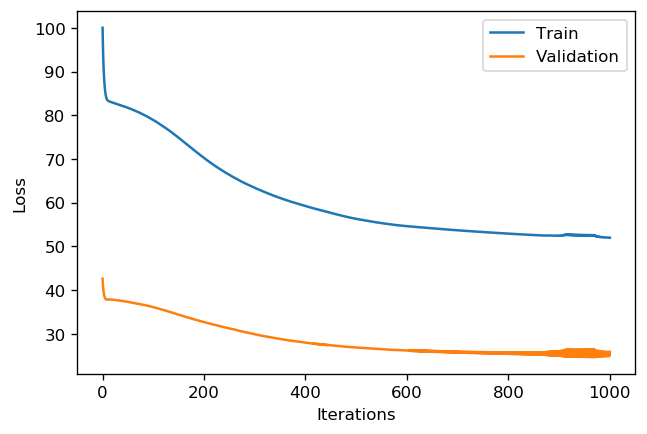

In [98]:
plt.plot(NN.losses)
plt.plot(NN.test_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(('Train','Validation'))
plt.show()

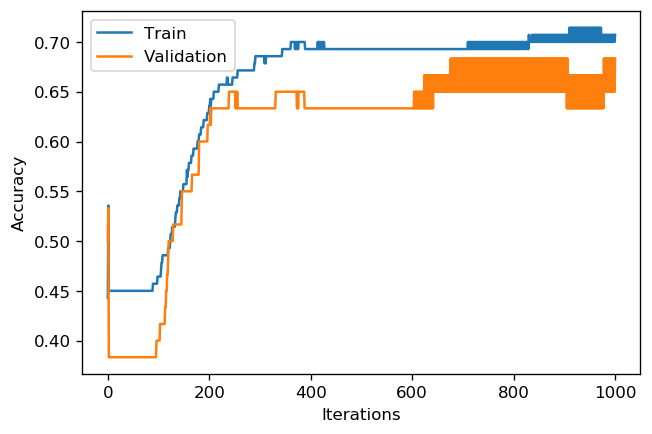

In [99]:
plt.plot(NN.accuracies)
plt.plot(NN.test_accuracies)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(('Train','Validation'))
plt.show()